In [43]:
using LinearAlgebra
using JuMP
using MathOptInterface
using Dualization
using Convex
using MosekTools
using Plots
using Statistics
using ControlSystems
using Dates
using DelimitedFiles

---------------------------

In [44]:
# The non-block dynamics of an LTI system
struct Lti
    n::Int64 # State dimension
    m::Int64 # Control dimension
    A::Matrix{Float64} # n x n matrix
    B::Matrix{Float64} # n x m matrix
    sigma::Float64
    Lti(A, B, sigma) = (
        A = Matrix{Float64}(A);
        B = Matrix{Float64}(B);
        sigma = Float64(sigma);
        (ah, aw) = size(A); @assert ah == aw;
        (bh, bw) = size(B); @assert bh == aw;
        new(ah, bw, A, B, sigma)
    )
end

# The Ocal matrix
function Ocal(L::Int64, X)
    (xh, xw) = size(X)
    @assert xh == xw
    M = zeros(0, xw)
    for t = 0:L-1; M = [M; X^t] end
    return Matrix{Float64}(M)
end

# The Tcal matrix
function Tcal(lti::Lti, L::Int64, X)
    n = lti.n
    A = lti.A
    (xh, xw) = size(X)
    @assert n == xh
    T = zeros(n * L, 0)
    Z = Matrix{Float64}(kron(Bidiagonal(zeros(L), ones(L - 1), :L), I(n)))
    for t = 1:L; T = [T (Z^t * Ocal(L, A) * X)] end
    return Matrix{Float64}(T)
end

# Block dynamics parameterized by a data of type Lti
struct BlockLti
    lti::Lti
    L::Int64
    Acal::Matrix{Float64} # nL x nL block matrix
    Bcal::Matrix{Float64} # nL x mL block matrix
    Zcal::Matrix{Float64} # nL x nL block matrix
    BlockLti(lti::Lti, L::Int64) = (
        In = Matrix{Float64}(I(lti.n));
        Acal = kron(I(L), lti.A);
        Bcal = kron(I(L), lti.B);
        Zcal = Matrix{Float64}(kron(Bidiagonal(zeros(L), ones(L - 1), :L), In));
        new(lti, L, Acal, Bcal, Zcal)
    )
end
;

In [45]:
# Explicitly store information about a Hankel matrix in a struct
struct Hankel
    d::Int64 # Dimension of underlying signal
    L::Int64
    T::Int64
    H::Matrix{Float64} # dL x (T - L + 1) dimensional block matrix
    Hankel(d::Int64, H) = (
        H = Matrix{Float64}(H);
        (hh, hw) = size(H);
        @assert mod(hh, d) == 0;
        L = Int64(hh / d);
        T = hw + L - 1;
        new(d, L, T, H)
    )
end

# Generate a trajectory of states starting from x0,
# given a control sequence u and noise sequence w,
# with respect to the dynamics given by lti::Lti
function xtraj(lti::Lti, x0::Array{Float64}, u::Array{Float64}, w::Array{Float64})
    n = lti.n; m = lti.m; A = lti.A; B = lti.B
    
    @assert length(x0) == n
    @assert length(u) / m == length(w) / n
    @assert mod(length(u), m) == 0
    @assert mod(length(w), n) == 0
    
    T = Int64(length(u) / m)
    
    x = zeros(n*T)
    x[1:n] = x0
    for t = 0:(T-2)
        (tlo, thi) = ((n * t) + 1, n * (t + 1))
        x[(tlo + n):(thi + n)] = A * x[tlo:thi] + B * u[tlo:thi] + w[tlo:thi]
    end
    
    return x
end

# We use z to denote system states _without_ process noise,
# so this merely passes w = zeros(n * T) to the xtraj function
function ztraj(lti::Lti, z0::Array{Float64}, u::Array{Float64})
    @assert mod(length(u), lti.m) == 0
    T = Int64(length(u) / lti.m)
    return xtraj(lti, z0, u, zeros(lti.n * T))
end

# Generate the Hankel data struct, assuming z is a stacked vector with block dimension d
function Hankelize(z::Array{Float64}, d::Int64, L::Int64)::Hankel
    N = Int64(round(length(z) / d))
    @assert length(z) == N * d
    z = reshape(z, (d, N))
    H = Matrix{Float64}(zeros(d * L, N - L + 1))
    for i = 1:(N - L + 1); H[:, i] = (z[:, i:(i + L - 1)])[:] end
    return Hankel(d, H)
end

# The Wcal matrices for relating the noisy states Hx to the noiseless Hz
function W(lti::Lti, t::Int64, w::Array{Float64})
    n = lti.n
    A = lti.A
    
    @assert mod(length(w), n) == 0
    
    acc = zeros(n)
    for k = 0:t-1
        (wlo, whi) = ((n * k) + 1, n * (k + 1))
        acc = acc + A^(t - 1 - k) * w[wlo:whi]
    end
    return acc
end
;

In [46]:
# System dynamics of the slightly unstable graph Laplacian
lti = Lti(
    # A
    [ 1.01 0.01 0.00;
      0.01 1.01 0.01;
      0.00 0.01 1.01 ],
    
    # B
    Matrix{Float64}(I(3)),
    
    # sigma
    sqrt(0.1)
)

Lti(3, 3, [1.01 0.01 0.0; 0.01 1.01 0.01; 0.0 0.01 1.01], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], 0.31622776601683794)

In [47]:
# Sanity check things about the (block) system dynamics;
# Will cause an assertion failure if something is wrong
function sanitycheck()
    # Hankel matrix parameters
    L = 10; T = 45
    blk = BlockLti(lti, L)
    ;

    N = 20
    x0 = [10.0; 10.0; 10.0]
    u = randn(lti.m * T)
    w = randn(lti.n * T) * (lti.sigma / sqrt(N))
    x = xtraj(lti, x0, u, w)
    z = ztraj(lti, x0, u)

    Hankx = Hankelize(x, lti.n, blk.L)
    Hankz = Hankelize(z, lti.n, blk.L)
    Hanku = Hankelize(u, lti.m, blk.L)
    Hankw = Hankelize(w, lti.n, blk.L)

    Wcal = zeros(lti.n, 0)
    for t = 0:T-L; Wcal = [Wcal W(lti, t, w)]end

    Eyen = Matrix{Float64}(I(lti.n))

    @assert norm(Hankz.H + Tcal(lti, L, Eyen) * Hankw.H + Ocal(L, lti.A) * Wcal - Hankx.H) < 0.00001
end

sanitycheck()

--------------------

In [48]:
# The LQR cost data
struct Lqr
    n::Int64
    m::Int64
    Q::Matrix{Float64}
    R::Matrix{Float64}
    sigma::Float64
    Lqr(Q, R, sigma) = (
        Q = Matrix{Float64}(Q);
        R = Matrix{Float64}(R);
        sigma = Float64(sigma);
        (qh, qw) = size(Q); @assert qh == qw;
        (rh, rw) = size(R); @assert rh == rw;
        new(qh, rh, Q, R, sigma)
    )
end

# The LQR, except in block form, so the Qcal, Rcal etc matrices are also stored
# This distinction is made to reflect the Lti vs BlockLti structs earlier
struct BlockLqr
    lqr::Lqr
    L::Int64
    Qcal::Matrix{Float64}
    Rcal::Matrix{Float64}
    sqrtQcal::Matrix{Float64}
    sqrtRcal::Matrix{Float64}
    BlockLqr(lqr::Lqr, L::Int64, QL, RL) = (
        @assert size(lqr.Q) == size(QL);
        (qh, qw) = size(QL);
        Qcal = kron(I(L), lqr.Q);
        Qcal[(end - qh + 1):end, (end - qw + 1):end] = QL;
        
        @assert size(lqr.R) == size(RL);
        (rh, rw) = size(RL);
        Rcal = kron(I(L), lqr.R);
        Rcal[(end - rh + 1):end, (end - rw + 1):end] = RL;
        
        sqrtQcal = sqrt(Qcal);
        sqrtRcal = sqrt(Rcal);
        new(lqr, L, Qcal, Rcal, sqrtQcal, sqrtRcal)
    )    
end
;

In [49]:
# Expression of the Block LQR cost, before the Frobenius norm is taken
function LqrExpr(blqr::BlockLqr, PhiX, PhiU)
    E = blqr.lqr.sigma * [blqr.sqrtQcal * PhiX; blqr.sqrtRcal * PhiU]
    return E
end

# Generate an Ocal(Z')' matrix as used in the paper
function OcalZ(blk::BlockLti)
    return Matrix{Float64}(Ocal(L, blk.Zcal')')
end

# Given the system (blk::BlockLti), costs (blqr::BlockLqr),
# and data matrices (Hx::Hankel, Hu::Hankel), synthesize a G.
# Additional parameters include whether we are doing robust synthesis
function findG(blk::BlockLti, blqr::BlockLqr, Hx::Hankel, Hu::Hankel; robust=false, epsilon=-1, gamma=0.0)
    # Problem dimensions
    n = blk.lti.n; m = blk.lti.m;
    L = Hx.L; T = Hx.T
    
    # Sanity check dimensions and whether robustness is enabled
    @assert (m, n) == (Hu.d, Hx.d)
    @assert (Hx.L, Hx.T) == (Hu.L, Hu.T)
    # robust == true implies (gamma > 0) and (epsilon > 0)
    @assert (!robust) || (gamma > 0 && epsilon > 0)
    
    # Swap these two lines to dualize the problem, or not
    model = Model(dual_optimizer(optimizer_with_attributes(
    # model = Model((optimizer_with_attributes(
            Mosek.Optimizer,
            # "QUIET" => false,
            "QUIET" => true,
            "INTPNT_CO_TOL_DFEAS" => 1e-9
        )))
    
    # Declare the G matrix
    (gh, gw) = (T - L + 1, n)
    @variable(model, G[1:(gh * L), 1:(gw * L)])
    
    # Declare a cost variable
    @variable(model, cost)
    
    # The PhiX and PhiU matrices can be defined in terms of G
    PhiX = OcalZ(blk) * kron(I(L), Hx.H) * G
    PhiU = OcalZ(blk) * kron(I(L), Hu.H) * G
    
    # Encode the objective cost this way because of JuMP's API
    @constraint(model, [cost; vec(LqrExpr(blqr, PhiX, PhiU))] in SecondOrderCone())
    
    # Block diagonals are in the Gamma set
    for k = 0:L-1
        # Diagonal is identity in the PhiX matrix
        (plo, phi) = (k * n + 1, k * n + n)
        @constraint(model, PhiX[plo:phi, plo:phi] .== Matrix{Float64}(I(n)))
        
        # If robustness is enabled, additionally enable opnorm constraints
        if robust
            (grlo, grhi) = (k * gh + 1, k * gh + gh)
            (gclo, gchi) = (k * gw + 1, k * gw + gw)
            Gk = G[grlo:grhi, gclo:gchi]
            gnorm = gamma / (epsilon * sqrt(L))
            @constraint(model, [gnorm; vec(Gk)] in MOI.NormSpectralCone(gh, gw))
        end
    end
    
    # Block lower triangular structure
    for i = 0:(L - 1)
        for j = (i + 1):(L - 1)
            (xrlo, xrhi) = (i * n + 1, i * n + n)
            (xclo, xchi) = (j * n + 1, j * n + n)
            @constraint(model, PhiX[xrlo:xrhi, xclo:xchi] .== zeros(n, n))
            
            (urlo, urhi) = (i * m + 1, i * m + m)
            (uclo, uchi) = (j * n + 1, j * n + n)
            @constraint(model, PhiU[urlo:urhi, uclo:uchi] .== zeros(m, n))
            
            (grlo, grhi) = (i * gh + 1, i * gh + gh)
            (gclo, gchi) = (j * gw + 1, j * gw + gw)
            @constraint(model, G[grlo:grhi, gclo:gchi] .== Matrix{Float64}(zeros(gh, gw)))
        end
    end
    
    # The strictly lower block triangles of G are also zero
    for i = 0:(L - 1)
        for j = 0:(i - 1)
            (grlo, grhi) = (i * gh + 1, i * gh + gh)
            (gclo, gchi) = (j * gw + 1, j * gw + gw)
            @constraint(model, G[grlo:grhi, gclo:gchi] .== Matrix{Float64}(zeros(gh, gw)))
        end
    end

    # For the robust problem, the  1/(1-gamma) part is done in the outer quasi-convex loop
    @objective(model, Min, cost)
        
    optimize!(model)
    return (model, value.(G))
end
;

In [72]:
# Non-robust synthesis
function findGstar(blk::BlockLti, blqr::BlockLqr, Hz::Hankel, Hu::Hankel)
    return findG(blk, blqr, Hz, Hu, robust=false)
end

# Identical to findGstar, except the parameter is named differently for semantics
function findGnom(blk::BlockLti, blqr::BlockLqr, Hx::Hankel, Hu::Hankel)
    return findG(blk, blqr, Hx, Hu, robust=false)
end

# Find a robust G wrt some epsilon > 0
function findGrob(blk::BlockLti, blqr::BlockLqr, Hx::Hankel, Hu::Hankel, epsilon)
    n = blk.lti.n; m = blk.lti.m
    L = Hx.L; T = Hx.T
    @assert (m, n) == (Hu.d, Hx.d)
    @assert (Hx.L, Hx.T) == (Hu.L, Hu.T)
    @assert epsilon > 0
    
    # Search range of gamma
    (left, right) = (1e-4, 0.9999)
    mid = (left + right) / 2
    
    # model and Grob are what we eventually return
    model = Model()
    Grob = zeros(n * L, T - L + 1)
    
    # Counters
    feasible = false
    iters = 0
    
    while (right - left > 1e-1)
        mid = (left + right) / 2
        
        iters = iters + 1
        println("Bisection at iteration: " * string(iters))
        
        (itermodel, iterG) = findG(blk, blqr, Hx, Hu, robust=true, epsilon=epsilon, gamma=mid)
        
        if termination_status(itermodel) == MOI.OPTIMAL
            model = itermodel
            Grob = iterG
            right = mid
            feasible = true
        else
            left = mid
        end
    end
    
    println("Total iterations: " * string(iters))
    
    if !feasible
       println("Warning: problem was never feasible at epsilon = " * string(epsilon)) 
    end
    
    return (model, Grob, mid)
end

;

In [73]:
# Define the LQR costs
lqr = Lqr(1e-3 * Matrix{Float64}(I(lti.n)), Matrix{Float64}(I(lti.m)), lti.sigma)
blqr = BlockLqr(lqr, blk.L, 4e2 * lqr.Q, lqr.R)

# While we're at it, we can also examine the DARE solution
P = dlqr(lti.A, lti.B, lqr.Q, lqr.R)

;

In [74]:
function trueLqrCost(blk::BlockLti, blqr::BlockLqr, K::Matrix{Float64})
    (kh, kw) = size(K)
    @assert kh == blk.lti.m * L
    @assert kw == blk.lti.n * L
    
    PhiXtrue = inv(I - blk.Zcal * (blk.Acal + blk.Bcal * K))
    
    J = blqr.lqr.sigma * norm(vec([blqr.sqrtQcal * PhiXtrue; blqr.sqrtRcal * K * PhiXtrue]))
    return J
end
;

In [75]:
function sanitycheck2()
    (model, Gstar) = findGstar(blk, blqr, Hankz, Hanku)
    PhiZstar = OcalZ(blk) * kron(I(L), Hankz.H) * Gstar
    PhiUstar = OcalZ(blk) * kron(I(L), Hanku.H) * Gstar
    Kstar = PhiUstar * inv(PhiZstar)

    (_, Gnom) = findGnom(blk, blqr, Hankx, Hanku)
    PhiXnom = OcalZ(blk) * kron(I(L), Hankx.H) * Gnom
    PhiUnom = OcalZ(blk) * kron(I(L), Hanku.H) * Gnom
    Knom = PhiUnom * inv(PhiXnom)

    @time (_, Grob, gammarob) = findGrob(blk, blqr, Hankx, Hanku, 0.1)
    PhiXrob = OcalZ(blk) * kron(I(L), Hankx.H) * Grob
    PhiUrob = OcalZ(blk) * kron(I(L), Hanku.H) * Grob
    Krob = PhiUrob * inv(PhiXrob)

    Jstar = trueLqrCost(blk, blqr, Kstar)
    Jnom = trueLqrCost(blk, blqr, Knom)
    Jrob = trueLqrCost(blk, blqr, Krob)
    
    println("(Jstar, Jnom, Jrob) = " * string((Jstar, Jnom, Jrob)))

    println("rel err of Jnom vs Jstar = " * string((Jnom - Jstar) / Jstar))

    println("rel err of Jrob (eps=0.1) vs Jstar = " * string((Jrob - Jstar) / Jstar))

    println("rel err of Jrob (eps=0.1) vs Jnom = " * string((Jrob - Jnom) / Jnom))
 
end
sanitycheck2()
;

Bisection at iteration: 1
Bisection at iteration: 2
Bisection at iteration: 3
Bisection at iteration: 4
Total iterations: 4
  9.237761 seconds (10.58 M allocations: 20.776 GiB, 20.72% gc time)
(Jstar, Jnom, Jrob) = (0.7538611833785269, 1.1405819562763257, 1.014667025167703)
rel err of Jnom vs Jstar = 0.5129867161546365
rel err of Jrob (eps=0.1) vs Jstar = 0.3459600355337846
rel err of Jrob (eps=0.1) vs Jnom = -0.11039533846361993


-----------------------------------------------

In [85]:

# A single step of the MPC
# Given x(t), figure out u(t) to derive x(t+1)
function MpcStep(blk::BlockLti, K::Matrix{Float64}, xt::Array{Float64})
    (n, m) = (blk.lti.n, lti.m)
    (A, B, sigma) = (blk.lti.A, blk.lti.B, blk.lti.sigma)
    L = blk.L
    
    @assert (m * L, n * L) == size(K)
    @assert length(xt) == n
    
    uts = K[:,1:n] * xt
    ut = uts[1:m]
    
    wt = sigma * randn(n)
    xt1 = A * xt + B * ut + wt
    
    return (xt1, ut, wt)
    
end

# Run an MPC using some K over horizon H and get the LQR costs
function MpcLoop(blk::BlockLti, K::Matrix{Float64}, x0::Array{Float64}; H=100)
    n = blk.lti.n
    m = blk.lti.m
    L = blk.L
    (kh, kw) = size(K)
    @assert size(K) == (L * m, L * n)
    
    xhist = x0
    xt = x0
    uhist = []
    whist = []
    for t = 0:H-1
        (xt1, ut, wt) = MpcStep(blk, K, xt)
        uhist = [uhist; ut]
        whist = [whist; wt]
        xt = xt1
        if t < H - 1; xhist = [xhist; xt1] end
    end
    
    return (xhist, uhist, whist)
end

# Cost of using a particular G in the MPC loop
function MpcLoopCost(blk::BlockLti, blqr::BlockLqr, Hx::Hankel, Hu::Hankel, G, x0, H)
    PhiX = OcalZ(blk) * kron(I(L), Hx.H) * G
    PhiU = OcalZ(blk) * kron(I(L), Hu.H) * G
    K = PhiU * inv(PhiX)
    (xH, uH, _) = MpcLoop(blk, K, x0, H)
    bigQ = kron(I(H), blqr.lqr.Q)
    bigR = kron(I(H), blqr.lqr.R)
    sqrtBigQ = sqrt(bigQ)
    sqrtBigR = sqrt(bigR)
    J = lqr.sigma * norm(vec([sqrtBigQ * xH; sqrtBigR * uH]))
    return J
end
;

In [93]:
bootvals = [
#     (10, 1.2451208309269783)    ;
#     (20, 0.8800208738612182)    ;
#     (40, 0.6221722052666475)    ;
#     (80, 0.4391189684675182)    ;
#     (160, 0.3126961297989887)   ;
#     (320, 0.2238407593985623)   ;
#     (640, 0.15557654473097288)  ;
#     (1280, 0.110852519282565)   ;
    (2560, 0.07787090540704344) ;
#     (5120, 0.055482199975597016)
    ]

Bmax = length(bootvals)
Mmax = 2
Jstars = zeros(Bmax, Mmax)
Jnoms = zeros(Bmax, Mmax)
JrobBs = zeros(Bmax, Mmax)
gammaBs = zeros(Bmax, Mmax)
JrobTs = zeros(Bmax, Mmax)
gammaTs = zeros(Bmax, Mmax)

@assert L == 10
@assert T == 45

# Control horizon
H = 100

println(Dates.format(now(), "HH:MM:SS") * " @ loop start")

for bi in 1:Bmax
    (N, epsilonboot) = bootvals[bi]
    
    println(Dates.format(now(), "HH:MM:SS") * " @ bi = " * string(bi))
    
    for mi = 1:Mmax
        println(Dates.format(now(), "HH:MM:SS") * " @ mi = " * string(mi))

        # Generate N random trajectories
        x0 = zeros(lti.n)
        avgz = zeros(lti.n * T)
        avgx = zeros(lti.n * T)
        avgu = zeros(lti.m * T)
        avgw = zeros(lti.n * T)
        
        for k = 1:N
            u = randn(lti.m * T)
            w = lti.sigma * randn(lti.n * T)
            x = xtraj(lti, x0, u, w)
            z = ztraj(lti, x0, u)
            
            avgz = avgz + z
            avgx = avgx + x
            avgu = avgu + u
            avgw = avgw + w
        end
        
        # ... and average the N random trajectories
        avgz = avgz / N
        avgx = avgx / N
        avgu = avgu / N
        avgw = avgw / N
        
#         avgw = (lti.sigma / sqrt(N)) * randn(lti.n * T)
#         avgu = randn(lti.m * T)
#         avgx = xtraj(lti, x0, avgu, avgw)
#         avgz = ztraj(lti, x0, avgu)
        
        # Use this to build some Hankel matrices
        Hx = Hankelize(avgx, lti.n, L)
        Hz = Hankelize(avgz, lti.n, L)
        Hu = Hankelize(avgu, lti.m, L)
        Hw = Hankelize(avgw, lti.n, L)
        
        epsilontrue = opnorm(Hw.H)
        
        println("(epsB, epsT) = " * string((epsilonboot, epsilontrue)))
        
        (modstar, Gstar) = findGstar(blk, blqr, Hz, Hu)
        if termination_status(modstar) == MOI.OPTIMAL
            Jstars[bi, mi] = MpcLoopCost(blk, blqr, Hz, Hu, Gstar, x0, H)
            println("Jstar @ " * string((N, mi)) * " = " * string(Jstars[bi, mi]))
            # Jstars[bi, mi] = trueLqrCost(blk, blqr, Kstar)
        else
            Jstars[bi, mi] = Inf
           println("Jstar @ " * string((N, mi)) * " INFEASIBLE!") 
        end
            
        (modnom, Gnom) = findGnom(blk, blqr, Hx, Hu)
        if termination_status(modnom) == MOI.OPTIMAL
            Jnoms[bi, mi] = MpcLoopCost(blk, blqr, Hx, Hu, Gnom, x0, H)
            println("Jnom @ " * string((N, mi)) * " = " * string(Jnoms[bi, mi]))
            # Jnoms[bi, mi] = trueLqrCost(blk, blqr, Knom)
        else
            Jnoms[bi, mi] = Inf
            println("Jnom @ " * string((N, mi)) * " INFEASIBLE!")
        end
            
        (modrobB, GrobB, gammaB) = findGrob(blk, blqr, Hx, Hu, epsilonboot)
        if termination_status(modrobB) == MOI.OPTIMAL
            JrobBs[bi, mi] = MpcLoopCost(blk, blqr, Hx, Hu, GrobB, x0, H)
            gammaBs[bi, mi] = gammaB
            println("JrobB @ " * string((N, mi)) * " = " * string(JrobBs[bi, mi]))
            # JrobBs[bi, mi] = trueLqrCost(blk, blqr, KrobB)
        else
            JrobBs[bi, mi] = Inf
            gammaBs[bi, mi] = Inf
            println("JrobB @ " * string((N, mi)) * " INFEASIBLE!")
        end
            
        (modrobT, GrobT, gammaT) = findGrob(blk, blqr, Hx, Hu, epsilontrue)
        if termination_status(modrobT) == MOI.OPTIMAL
            JrobTs[bi, mi] = MpcLoopCost(blk, blqr, Hx, Hu, GrobT, x0, H)
            gammaTs[bi, mi] = gammaT
            println("JrobT @ " * string((N, mi)) * " = " * string(JrobTs[bi, mi]))
            # JrobTs[bi, mi] = trueLqrCost(blk, blqr, KrobT)
        else
            JrobTs[bi, mi] = Inf
            gammaTs[bi, mi] = Inf
            println("JrobT @ " * string((N, mi)) * " INFEASIBLE!")
        end
    end
end


println(Dates.format(now(), "HH:MM:SS") * " @ loop end")

20:50:33 @ loop start
20:50:33 @ bi = 1
20:50:33 @ mi = 1
(epsB, epsT) = (0.07787090540704344, 0.0684551246536604)
Jstar @ (2560, 1) = 0.38291428646572645
Jnom @ (2560, 1) = 0.6838773957657133
Bisection at iteration: 1
Bisection at iteration: 2
Bisection at iteration: 3
Bisection at iteration: 4
Total iterations: 4
JrobB @ (2560, 1) INFEASIBLE!
Bisection at iteration: 1
Bisection at iteration: 2
Bisection at iteration: 3
Bisection at iteration: 4
Total iterations: 4
JrobT @ (2560, 1) INFEASIBLE!
20:50:56 @ mi = 2
(epsB, epsT) = (0.07787090540704344, 0.05703704046810524)
Jstar @ (2560, 2) = 0.3346460154693173
Jnom @ (2560, 2) = 0.3096583633741343
Bisection at iteration: 1
Bisection at iteration: 2
Bisection at iteration: 3
Bisection at iteration: 4
Total iterations: 4
JrobB @ (2560, 2) INFEASIBLE!
Bisection at iteration: 1
Bisection at iteration: 2
Bisection at iteration: 3
Bisection at iteration: 4
Total iterations: 4
JrobT @ (2560, 2) INFEASIBLE!
20:51:20 @ loop end


In [94]:
# Rows: N = 10, 20, 40, 80, 160, 320, 640, 1280, 2560
[mean(Jstars, dims=2) mean(Jnoms, dims=2) mean(JrobBs, dims=2) mean(JrobTs, dims=2)]

1×4 Array{Float64,2}:
 0.35878  0.496768  Inf  Inf

In [92]:
Jstarsmed = [median(Jstars[b,:]) for b = 1:Bmax]
Jnomsmed = [median(Jnoms[b,:]) for b = 1:Bmax]
JrobBsmed = [median(JrobBs[b,:]) for b = 1:Bmax]
JrobTsmed = [median(JrobTs[b,:]) for b = 1:Bmax]
[Jstarsmed Jnomsmed JrobBsmed JrobTsmed]

1×4 Array{Float64,2}:
 0.419226  0.581814  Inf  Inf

In [80]:
JstarsQ1 = [quantile(Jstars[b,:], 0.25) for b = 1:Bmax]
JstarsQ3 = [quantile(Jstars[b,:], 0.75) for b = 1:Bmax]

JnomsQ1 = [quantile(Jnoms[b,:], 0.25) for b = 1:Bmax]
JnomsQ3 = [quantile(Jnoms[b,:], 0.75) for b = 1:Bmax]

JrobBsQ1 = [quantile(JrobBs[b,:], 0.25) for b = 1:Bmax]
JrobBsQ3 = [quantile(JrobBs[b,:], 0.75) for b = 1:Bmax]

JrobTsQ1 = [quantile(JrobTs[b,:], 0.25) for b = 1:Bmax]
JrobTsQ3 = [quantile(JrobTs[b,:], 0.75) for b = 1:Bmax]

3-element Array{Float64,1}:
 NaN
 NaN
 NaN

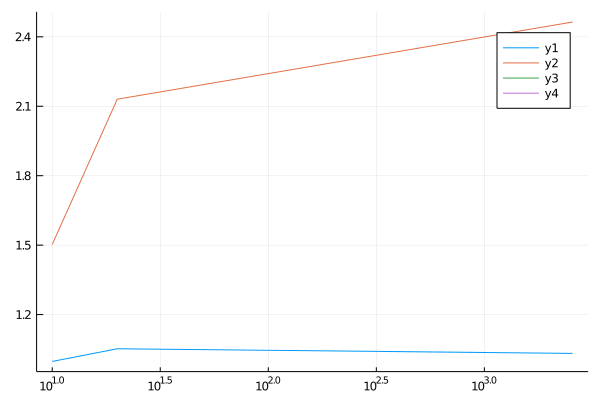

In [81]:
Ns = [boot[1] for boot in bootvals]

plot(Ns, Jstarsmed, ribbon = (Jstarsmed - JstarsQ1, JstarsQ3 - Jstarsmed), fillalpha=0.2, xscale=:log10)
plot!(Ns, Jnomsmed, ribbon = (Jnomsmed - JnomsQ1, JnomsQ3 - Jnomsmed), fillalpha=0.2)
plot!(Ns, JrobBsmed, ribbon = (JrobBsmed - JrobBsQ1, JrobBsQ3 - JrobBsmed), fillalpha=0.2)
plot!(Ns, JrobTsmed, ribbon = (JrobTsmed - JrobTsQ1, JrobTsQ3 - JrobTsmed), fillalpha=0.2)

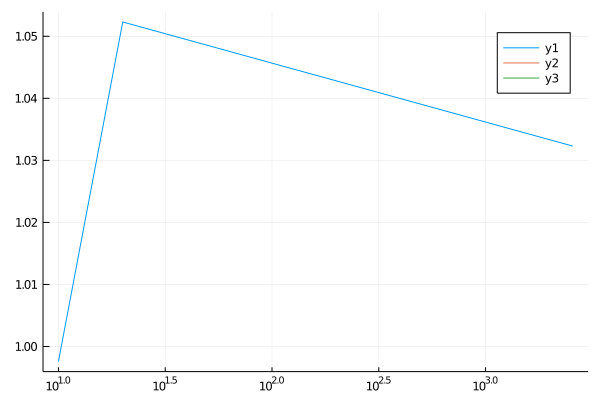

In [82]:

plot(Ns, Jstarsmed, ribbon = (Jstarsmed - JstarsQ1, JstarsQ3 - Jstarsmed), fillalpha=0.2, xscale=:log10)
# plot!(Ns, Jnomsmed, ribbon = (Jnomsmed - JnomsQ1, JnomsQ3 - Jnomsmed), fillalpha=0.2)
plot!(Ns, JrobBsmed, ribbon = (JrobBsmed - JrobBsQ1, JrobBsQ3 - JrobBsmed), fillalpha=0.2)
plot!(Ns, JrobTsmed, ribbon = (JrobTsmed - JrobTsQ1, JrobTsQ3 - JrobTsmed), fillalpha=0.2)

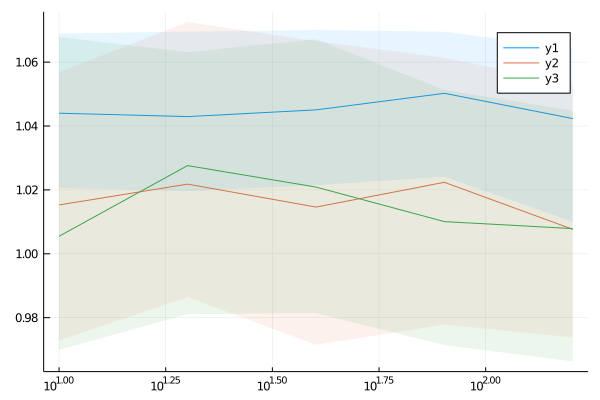

In [300]:

plot(Ns[1:5], Jstarsmed[1:5], ribbon = (Jstarsmed[1:5] - JstarsQ1[1:5], JstarsQ3[1:5] - Jstarsmed[1:5]), fillalpha=0.1, xscale=:log10)
# plot!(Ns, Jnomsmed, ribbon = (Jnomsmed - JnomsQ1, JnomsQ3 - Jnomsmed), fillalpha=0.1)
plot!(Ns[1:5], JrobBsmed[1:5], ribbon = (JrobBsmed[1:5] - JrobBsQ1[1:5], JrobBsQ3[1:5] - JrobBsmed[1:5]), fillalpha=0.1)
plot!(Ns[1:5], JrobTsmed[1:5], ribbon = (JrobTsmed[1:5] - JrobTsQ1[1:5], JrobTsQ3[1:5] - JrobTsmed[1:5]), fillalpha=0.1)

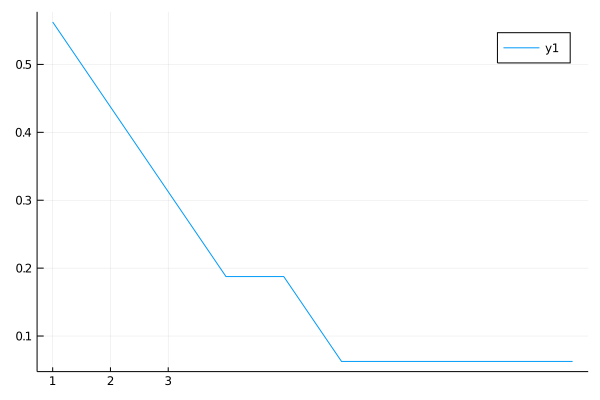

In [323]:
gammaBsmed = [median(gammaBs[b,:]) for b in 1:Bmax]
gammaTsmed = [median(gammaTs[b,:]) for b in 1:Bmax]

plot(1:10, gammaBsmed, xticks=)
# plot!(1:10, gammaTsmed)

In [278]:
# Save a bunch of results.
# Make sure to check which directory you are in

open("Jstars.txt", "w") do io
    writedlm(io, Jstars)
end

open("Jnoms.txt", "w") do io
    writedlm(io, Jnoms)
end

open("JrobBs.txt", "w") do io
    writedlm(io, JrobBs)
end

open("JrobTs.txt", "w") do io
    writedlm(io, JrobTs)
end

open("gammaBs.txt", "w") do io
    writedlm(io, gammaBs)
end

open("gammaTs.txt", "w") do io
    writedlm(io, gammaTs)
end




--------------------------------